In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
import counterstone as cs

IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
toxdata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/clintox.csv.gz')
toxdata = toxdata.iloc[:200, :]
toxdata.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [2]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
raw_features = calc.pandas(valid_mols)
labels = toxdata[valid_mol_idx].FDA_APPROVED

 12%|█▏        | 24/199 [00:02<00:24,  7.12it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 61%|██████    | 121/199 [00:08<00:21,  3.58it/s]

/home/whitead/miniconda3/envs/mmm/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 199/199 [00:10<00:00, 19.83it/s]


In [3]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True)

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.6319444444444444

In [5]:
example = toxdata.smiles.iloc[valid_mol_idx][0]
example_y = clf.predict(features[0:1])

def model_eval(smiles, selfies):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    features = calc.pandas(molecules, quiet=True)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = clf.predict(features)
    #return (example_y - labels).astype(bool)
    return np.random.choice([True, False], size=labels.shape)
model_eval(['CC', 'CC=O'], [])

array([ True, False])

In [6]:
exps = cs.explain(example[1:], model_eval)

NUMBER OF UNIQUE SMILES 738
[1 2 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 3 1 1 3 1
 1 1 0 1 1 0 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1
 1 1 4 1 1 1 1 1 1 1 1 1 1 3 3 1 1 3 8 1 3 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 1 1 1 3 1 1 3 1 1 1 1 1 1 1 3 1 3 1 1 1 1 8 1 3 1 9 1 1 5 1 1 1 1 1 1 1
 1 1 1 2 1 6 1 1 1 1 1 1 1 1 2 1 3 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 4 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 1 1 1]


In [7]:
exps

[Explanation(smiles='C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC', selfies=None, similarity=1.0, position=array([0, 0]), is_base=True),
 Explanation(smiles='CCC1(NC(=O)OOCCOC)CCCCNC(=O)OCC1', selfies='', similarity=0.18867924528301888, position=array([4.44185894, 0.17922789]), is_base=False),
 Explanation(smiles='COCCOC(=O)NCCCC(C=O)NC(=O)OCCOC', selfies='', similarity=0.9230769230769231, position=array([-2.85695078,  0.5750868 ]), is_base=False),
 Explanation(smiles='CC(COCCO)NC(=O)C=O', selfies='', similarity=0.18518518518518517, position=array([ 4.41929221, -0.3200566 ]), is_base=False),
 Explanation(smiles='COCCOC(=O)NCCCC(C)C=O', selfies='', similarity=0.5, position=array([-0.14043762, -0.10625006]), is_base=False),
 Explanation(smiles='CNC(=O)OCCC=O', selfies='', similarity=0.2054794520547945, position=array([ 4.09740419, -0.11474328]), is_base=False),
 Explanation(smiles='[O-]O', selfies=None, similarity=0.0, position=array([7.65237624, 0.04737228]), is_base=False),
 Explanation(smil

IndexError: index 8 is out of bounds for axis 0 with size 8

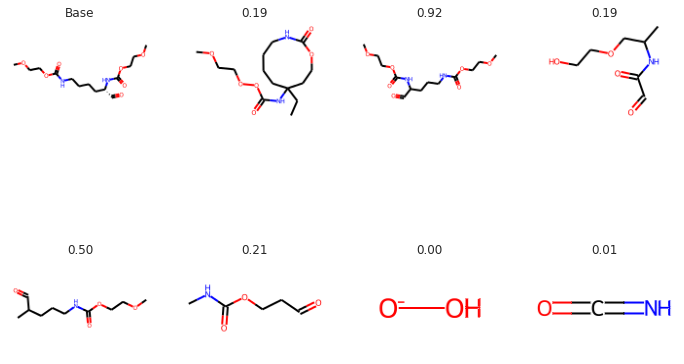

In [9]:
cs.plot_explanation(exps)